In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.classify.maxent import MaxentClassifier
from sklearn.model_selection import train_test_split
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import gc

from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../input/train-sim/train.csv')
df['type'] = df['id'].str[:10]
df = df[df['type'] == 'sodepami_v']
df = df.sample(688000)

In [4]:
# df1 = pd.read_csv('../input/train-sim/train.csv')
# df1 = df1[df1['price_vnd']>=5e6]

In [5]:
# df = pd.concat([df,df1])

In [6]:
df.shape

(688000, 5)

In [7]:
def removing_wrong_phone_number(df):
    df['phone_number'] = df['phone_number'].astype(str)
    list_number = df['phone_number'].to_list()
    list_len = []

    for i in range(len(list_number)):
        list_len.append(len(list_number[i]))

    df['length'] = list_len

    df = df[df['length'] != 11]

    return df

In [8]:
df = removing_wrong_phone_number(df)

In [9]:
def creating_10_feats_from_single_pos(df):
    list_number = df['phone_number'].to_list()
    list_char = np.full((df.shape[0], 9), "-1")

    for i in range(len(list_number)):
        k = 8
        for j in range(len(list_number[i])-1, 0, -1):
            list_char[i][k] = list_number[i][j]
            k-=1
    
            if(k==0):
                list_char[i][k] = list_number[i][0:j]
                break
    for i in range(9):
        df['pos_' + str(i+1)] = list_char[:,i]
    return df

In [10]:
df = creating_10_feats_from_single_pos(df)
df.head(10)

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,pos_5,pos_6,pos_7,pos_8,pos_9
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,3,3,3,7,9
227230,350744,sodepami_vn_0765688234,765688234,1550000,sodepami_v,9,7,6,5,6,8,8,2,3,4
146815,815874,sodepami_vn_0328413234,328413234,1000000,sodepami_v,9,3,2,8,4,1,3,2,3,4
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,9,1,1,1,4
325108,1011933,sodepami_vn_0902563368,902563368,2600000,sodepami_v,9,9,0,2,5,6,3,3,6,8
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,3,5,1,1,1
179273,678207,sodepami_vn_0789261997,789261997,1550000,sodepami_v,9,7,8,9,2,6,1,9,9,7
858993,946371,sodepami_vn_0523136479,523136479,450000,sodepami_v,9,5,2,3,1,3,6,4,7,9
191125,784830,sodepami_vn_0819903168,819903168,790000,sodepami_v,9,8,1,9,9,0,3,1,6,8
794585,745615,sodepami_vn_0395792789,395792789,2700000,sodepami_v,9,3,9,5,7,9,2,7,8,9


In [11]:
def features_from_counting_numbers(df):
    list_number = df['phone_number'].to_list()
    
    list_count = np.full((df.shape[0], 10), 0)
    
    for i in range(len(list_number)):
        for j in range(len(list_number[i])):
            tmp = int(list_number[i][j])
            list_count[i][tmp] += 1  
    for i in range(10):
        df['count_' + str(i)] = list_count[:,i]
    
    max_count = [0 for i in range(len(list_number))]
    for i in range(len(list_number)):
        max_c = 0
        pos = 0
        for j in range(len(list_count[i])):
            if list_count[i][j] >= max_c:
                max_c = list_count[i][j]
                pos = j
        #print(max_c)
        max_count[i] = pos  
        
    df['max_count'] = max_count
    return df

In [12]:
df = features_from_counting_numbers(df)

In [13]:
def combo_feat(df):
    list_number = df['phone_number'].tolist()

    list_2_last = list() #extract 2 last digit

    list_3_last = list() #extract 3 last digit

    list_4_last = list() #extract 4 last digit

    list_5_last = list() #extract 5 last digit

    list_first = list() #extract first digit after 0

    list_combo_3_identical_bool = list() # the phone number contain 111, 222, ....999 or not

    list_combo_3_identical_cat = list() # the phone number contain which one of 111, 222, ....999

    list_combo_4_identical_bool = list() # the phone number contain 1111, 2222, ... or not

    list_combo_4_identical_cat = list()

    list_combo_5_identical_bool = list() # the phone number contain 11111, 22222, ... or not

    list_combo_5_identical_cat = list()

    list_combo_6_identical_bool = list() 

    list_combo_6_identical_cat = list() 

    list_3_combo_s = list() # tam hoa <5

    list_3_combo_57 = list() # tam hoa 5,7

    list_3_combo_689 = list() # tam hoa 6,8,9

    list_4_combo_s = list() # tu quy <5

    list_4_combo_57 = list() # tu quy 5,7

    list_4_combo_689 = list() # tu quy 6,8,9


    for i in range(len(list_number)):
            str_tmp_2_last = list_number[i][-2:]
            list_2_last.append(str_tmp_2_last)

            str_tmp_3_last = list_number[i][-3:]
            list_3_last.append(str_tmp_3_last)

            str_tmp_4_last = list_number[i][-4:]
            list_4_last.append(str_tmp_4_last)

            str_tmp_5_last = list_number[i][-5:]
            list_5_last.append(str_tmp_5_last)

            str_tmp_first = list_number[i][0]
            list_first.append(str_tmp_first)

            list_combo_3 = {'000','111','222','333','444','555','666','777','888','999'}
            combo_3_score = 0
            combo_3_cat = ""

            combo_3_s = 0
            combo_3_57 = 0
            combo_3_689 = 0

            for str_tmp in list_combo_3:
                if str_tmp in list_number[i]:
                    combo_3_score = combo_3_score + 1
                    combo_3_cat += str_tmp

                    x = (int)(str_tmp[0])

                    if(x in {0,1,2,3,4} ): 
                        combo_3_s = combo_3_s + 1
                    elif (x == 5 or x == 7 ):
                        combo_3_57 = combo_3_57 + 1    
                    else:
                        combo_3_689 = combo_3_689 + 1

            list_combo_3_identical_bool.append(combo_3_score)
            list_combo_3_identical_cat.append(combo_3_cat)

            list_3_combo_s.append(combo_3_s)
            list_3_combo_57.append(combo_3_57)
            list_3_combo_689.append(combo_3_689)

            list_combo_4 = {'0000','1111','2222','3333','4444','5555','6666','7777','8888','9999'}
            combo_4_score = 0
            combo_4_cat = ""

            combo_4_s = 0
            combo_4_57 = 0
            combo_4_689 = 0
            for str_tmp in list_combo_4:
                if str_tmp in list_number[i]:
                    combo_4_score = combo_4_score + 1
                    combo_4_cat += str_tmp

                    x = (int)(str_tmp[0])

                    if(x in {0,1,2,3,4} ): 
                        combo_4_s = combo_4_s + 1
                    elif (x == 5 or x == 7 ):
                        combo_4_57 = combo_4_57 + 1    
                    else:
                        combo_4_689 = combo_4_689 + 1            


            list_combo_4_identical_bool.append(combo_4_score)
            list_combo_4_identical_cat.append(combo_4_cat)

            list_4_combo_s.append(combo_4_s)
            list_4_combo_57.append(combo_4_57)
            list_4_combo_689.append(combo_4_689)

            list_combo_5 = {'00000','11111','22222','33333','44444','55555','66666','77777','88888','99999'}
            combo_5_score = 0
            combo_5_cat = ""
            for str_tmp in list_combo_5:
                if str_tmp in list_number[i]:
                    combo_5_score = combo_5_score + 1
                    combo_5_cat += str_tmp

            list_combo_5_identical_bool.append(combo_5_score)
            list_combo_5_identical_cat.append(combo_5_cat)


            list_combo_6 = {'000000','111111','222222','333333','444444','555555','666666','777777','888888','999999'}
            combo_6_score = 0
            combo_6_cat = ""

            for str_tmp in list_combo_6:
                if str_tmp in list_number[i]:
                    combo_6_score = combo_6_score + 1
                    combo_6_cat += str_tmp

            list_combo_6_identical_bool.append(combo_6_score)
            list_combo_6_identical_cat.append(combo_6_cat)

    df['2_last'] = list_2_last
    df['3_last'] = list_3_last
    df['4_last'] = list_4_last
    df['5_last'] = list_5_last
    df['first'] = list_first

    df['3_combo_bool'] = list_combo_3_identical_bool
    df['3_combo_cat'] = list_combo_3_identical_cat

    df['4_combo_bool'] = list_combo_4_identical_bool
    df['4_combo_cat'] = list_combo_4_identical_cat

    df['5_combo_bool'] = list_combo_5_identical_bool
    df['5_combo_cat'] = list_combo_5_identical_cat

    df['6_combo_bool'] = list_combo_6_identical_bool
    df['6_combo_cat'] = list_combo_6_identical_cat

    df['3_combo_s'] = list_3_combo_s
    df['3_combo_57'] = list_3_combo_57
    df['3_combo_689'] = list_3_combo_689

    df['4_combo_s'] = list_4_combo_s
    df['4_combo_57'] = list_4_combo_57
    df['4_combo_689'] = list_4_combo_689
        
    return df

In [14]:
df = combo_feat(df)

In [15]:
df[df['3_combo_bool']!=0]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,5_combo_bool,5_combo_cat,6_combo_bool,6_combo_cat,3_combo_s,3_combo_57,3_combo_689,4_combo_s,4_combo_57,4_combo_689
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,...,0,,0,,1,0,0,0,0,0
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,...,0,,0,,1,0,0,0,0,0
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,...,0,,0,,1,0,0,0,0,0
228501,453306,sodepami_vn_0777666680,777666680,5700000,sodepami_v,9,7,7,7,6,...,0,,0,,0,1,1,0,0,1
725853,325186,sodepami_vn_0899044449,899044449,1150000,sodepami_v,9,8,9,9,0,...,0,,0,,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266610,286154,sodepami_vn_0705177774,705177774,2400000,sodepami_v,9,7,0,5,1,...,0,,0,,0,1,0,0,1,0
644178,266133,sodepami_vn_0973865550,973865550,1080000,sodepami_v,9,9,7,3,8,...,0,,0,,0,1,0,0,0,0
20520,200607,sodepami_vn_0838333367,838333367,1100000,sodepami_v,9,8,3,8,3,...,0,,0,,1,0,0,1,0,0
672251,521534,sodepami_vn_0777107789,777107789,1700000,sodepami_v,9,7,7,7,1,...,0,,0,,0,1,0,0,0,0


In [16]:
# def lucky_2_last(df):
#     list_2_lucky_last_bool = list()
#     list_2_lucky_last_cat = list()

#     for i in list_2_last:
#         if (i == '68' or i == '86' or i == '78' or i == '79' or i == '39' or i == '38' or i =='83'):
#             list_2_lucky_last_bool.append(1)
#             list_2_lucky_last_cat.append(i)
#         else:
#             list_2_lucky_last_bool.append(0)
#             list_2_lucky_last_cat.append('')


#     df['2_lucky_last_bool'] = list_2_lucky_last_bool # check if the phone number has 2 last "lucky number" or not
#     df['2_lucky_last_cat'] = list_2_lucky_last_cat
    
#     return df


In [17]:
def sim_nam_sinh(df):
    list_nam_sinh_bool = []
    list_number = df['phone_number'].to_list()
    list_nam_sinh = []
    for i in list_number:
        if 1900 <= int(i[-4:]) <= 2022:
            list_nam_sinh.append(int(i[-4:]))
            list_nam_sinh_bool.append(1)
        else:
            list_nam_sinh.append(0)
            list_nam_sinh_bool.append(0)
            
    
    df['nam_sinh'] = list_nam_sinh
    df['nam_sinh_bool'] = list_nam_sinh_bool
    df['nam_sinh'] = df['nam_sinh'].astype(str)
    return df

In [18]:
df = sim_nam_sinh(df)

In [19]:
# df['nam_sinh'][df['nam_sinh_bool']!=0]

In [20]:
def symetric_4length_and_samesubtring_features(df):
    list_number = df['phone_number'].to_list()
    list_length_palindrome = []
    list_bool_palindrome = []
    list_palindrome = []
    list_same_substr = []
    list_same_substr_length = []
    list_bool_same_substr = []
    for i in range(len(list_number)):
        
        res = [list_number[i][x: y]+str(x) for x in range(len(list_number[i])-1)
              for y in range(x + 2, len(list_number[i])+1)]
                
        tmp = ""
        for j in res:
            if len(j[:-1])>=4  and len(j[:-1]) > len(tmp) and j[:-1] == j[:-1][::-1]:
                tmp = j[:-1]
        
         
        list_palindrome.append(tmp)
        list_length_palindrome.append(len(tmp))
        
        
        tmp2 = ""
                
                
        for j in range(len(res)-1):
            
            u1_n = (len(list_number[i]) - 1 - int(res[j][-1])) * len(res[j][:-1])
            ps = int(len(res[j][:-1]) * ( len(res[j][:-1])-1) / 2)
            
            
            for z in range(j + (u1_n - ps),len(res)):
                if res[j][:-1] == res[z][:-1] and len(res[j][:-1]) > len(tmp2):
                    tmp2 = res[z][:-1]
  
        list_same_substr.append(tmp2)
        list_same_substr_length.append(len(tmp2))
    
    for i in range(len(list_length_palindrome)):
        if list_length_palindrome[i] != 0:
            list_bool_palindrome.append(1)
        else:
            list_bool_palindrome.append(0)
        
        if list_same_substr_length[i] != 0:
            list_bool_same_substr.append(1)
        else:
            list_bool_same_substr.append(0)
        
    df['palindrome_length'] = list_length_palindrome
    df['palindrome'] = list_palindrome
    df['bool_palindrome'] = list_bool_palindrome
    df['list_same'] = list_same_substr
    df['list_same_substr_length'] = list_same_substr_length
    df['bool_substr'] = list_bool_same_substr
    return df

In [21]:
df = symetric_4length_and_samesubtring_features(df)
df.head(10)

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,4_combo_57,4_combo_689,nam_sinh,nam_sinh_bool,palindrome_length,palindrome,bool_palindrome,list_same,list_same_substr_length,bool_substr
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,...,0,0,0,0,0,,0,,0,0
227230,350744,sodepami_vn_0765688234,765688234,1550000,sodepami_v,9,7,6,5,6,...,0,0,0,0,0,,0,,0,0
146815,815874,sodepami_vn_0328413234,328413234,1000000,sodepami_v,9,3,2,8,4,...,0,0,0,0,0,,0,32,2,1
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,...,0,0,0,0,0,,0,,0,0
325108,1011933,sodepami_vn_0902563368,902563368,2600000,sodepami_v,9,9,0,2,5,...,0,0,0,0,4,6336,1,,0,0
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,...,0,0,0,0,0,,0,35,2,1
179273,678207,sodepami_vn_0789261997,789261997,1550000,sodepami_v,9,7,8,9,2,...,0,0,1997,1,0,,0,,0,0
858993,946371,sodepami_vn_0523136479,523136479,450000,sodepami_v,9,5,2,3,1,...,0,0,0,0,0,,0,,0,0
191125,784830,sodepami_vn_0819903168,819903168,790000,sodepami_v,9,8,1,9,9,...,0,0,0,0,0,,0,,0,0
794585,745615,sodepami_vn_0395792789,395792789,2700000,sodepami_v,9,3,9,5,7,...,0,0,0,0,0,,0,,0,0


In [22]:
df[df['bool_substr']==1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,4_combo_57,4_combo_689,nam_sinh,nam_sinh_bool,palindrome_length,palindrome,bool_palindrome,list_same,list_same_substr_length,bool_substr
146815,815874,sodepami_vn_0328413234,328413234,1000000,sodepami_v,9,3,2,8,4,...,0,0,0,0,0,,0,32,2,1
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,...,0,0,0,0,0,,0,35,2,1
410167,896500,sodepami_vn_0925681992,925681992,3020000,sodepami_v,9,9,2,5,6,...,0,0,1992,1,0,,0,92,2,1
228501,453306,sodepami_vn_0777666680,777666680,5700000,sodepami_v,9,7,7,7,6,...,0,1,0,0,4,6666,1,66,2,1
725853,325186,sodepami_vn_0899044449,899044449,1150000,sodepami_v,9,8,9,9,0,...,0,0,0,0,4,4444,1,44,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561972,831620,sodepami_vn_0799881998,799881998,12000000,sodepami_v,9,7,9,9,8,...,0,0,1998,1,0,,0,998,3,1
536170,1038621,sodepami_vn_0568726268,568726268,550000,sodepami_v,9,5,6,8,7,...,0,0,0,0,0,,0,68,2,1
412853,483267,sodepami_vn_0586890990,586890990,1100000,sodepami_v,9,5,8,6,8,...,0,0,0,0,4,0990,1,90,2,1
394932,830339,sodepami_vn_0823062345,823062345,2500000,sodepami_v,9,8,2,3,0,...,0,0,0,0,0,,0,23,2,1


In [23]:
# def combo_features(df):
#     list_number = df['phone_number'].tolist()
    
#     list_2_last = list() #extract 2 last digit
    
#     list_3_last = list() #extract 3 last digit
    
#     list_4_last = list() #extract 4 last digit
    
#     list_5_last = list() #extract 5 last digit
    
#     list_combo_3_identical = list() # the phone number contain 111, 222, ....999 or not
    
#     list_combo_4_identical = list() # the phone number contain 1111, 2222, ... or not
    
#     list_combo_5_identical = list() # the phone number contain 11111, 22222, ... or not
    
#     list_combo_6_identical = list() # the phone number contain 11111, 22222, ... or not
    
    
    
#     for i in range(len(list_number)):
#         str_2_last = list_number[i][-2:]
#         list_2_last.append(str_2_last)
    
#         str_3_last = list_number[i][-3:]
#         list_3_last.append(str_3_last)
    
#         str_4_last = list_number[i][-4:]
#         list_4_last.append(str_4_last)
    
#         str_5_last = list_number[i][-5:]
#         list_5_last.append(str_5_last)
    
    
#         list_combo_3 = ['000','111','222','333','444','555','666','777','888','999']
    
#         tmp = ""
#         for j in range(len(list_combo_3)):
#             if list_combo_3[j] in list_number[i]:
#                 tmp += list_combo_3[j]
    
#         list_combo_3_identical.append(tmp)
    
#         list_combo_4 = ['0000','1111','2222','3333','4444','5555','6666','7777','8888','9999']
#         tmp_4 = ""
    
#         for j in range(len(list_combo_4)):
#           if list_combo_4[j] in list_number[i]:
#                 tmp_4 += list_combo_4[j]
        
#         list_combo_4_identical.append(tmp_4)
    
#         list_combo_5 = ['00000','11111','22222','33333','44444','55555','66666','77777','88888','99999']
#         tmp_5 = ""
    
#         for j in range(len(list_combo_5)):
#             if list_combo_5[j] in list_number[i]:
#                 tmp_5 += list_combo_5[j]
        
#         list_combo_5_identical.append(tmp_5)
    
    
#         list_combo_6 = ['000000','111111','222222','333333','444444','555555','666666','777777','888888','999999']
#         tmp_6 = ""
    
#         for j in range(len(list_combo_6)):
#             if list_combo_6[j] in list_number[i]:
#                 tmp_6 += list_combo_6[j]
        
#         list_combo_6_identical.append(tmp_6)
    
#     df['2_last'] = list_2_last
#     df['3_last'] = list_3_last
#     df['4_last'] = list_4_last
#     df['5_last'] = list_5_last
#     df['3_combo'] = list_combo_3_identical
#     df['4_combo'] = list_combo_4_identical
#     df['5_combo'] = list_combo_5_identical
#     df['6_combo'] = list_combo_6_identical
    
#     return df

In [24]:
# df = combo_features(df)
# df.head()

In [25]:
def count_combo_features(df):
    list_number = df['phone_number'].to_list()
    list_combo_3_count = list() # the phone number contain 111, 222, ....999 or not
    
    list_combo_4_count = list() # the phone number contain 1111, 2222, ... or not
    
    list_combo_5_count = list() # the phone number contain 11111, 22222, ... or not
    
    list_combo_6_count = list() # the phone number contain 11111, 22222, ... or not
    
    
    
    for i in range(len(list_number)):
    
        list_combo_3 = {'000','111','222','333','444','555','666','777','888','999'}
        combo_3_score = 0
    
        for j in list_combo_3:
            if j in list_number[i]:
                combo_3_score = combo_3_score + 1
    
        list_combo_3_count.append(combo_3_score)
    
        list_combo_4 = {'0000','1111','2222','3333','4444','5555','6666','7777','8888','9999'}
        combo_4_score = 0
    
        for j in list_combo_4:
            if j in list_number[i]:
                combo_4_score = combo_4_score + 1
        
        list_combo_4_count.append(combo_4_score)
    
        list_combo_5 = {'00000','11111','22222','33333','44444','55555','66666','77777','88888','99999'}
        combo_5_score = 0
    
        for j in list_combo_5:
            if j in list_number[i]:
                combo_5_score = combo_5_score + 1
        
        list_combo_5_count.append(combo_5_score)
    
    
        list_combo_6 = {'000000','111111','222222','333333','444444','555555','666666','777777','888888','999999'}
        combo_6_score = 0
    
        for j in list_combo_6:
            if j in list_number[i]:
                combo_6_score = combo_6_score + 1
        
        list_combo_6_count.append(combo_6_score)
        
    df['3_combo_count'] = list_combo_3_count
    df['4_combo_count'] = list_combo_4_count
    df['5_combo_count'] = list_combo_5_count
    df['6_combo_count'] = list_combo_6_count
    
    return df

In [26]:
df = count_combo_features(df)
df.head()

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,palindrome_length,palindrome,bool_palindrome,list_same,list_same_substr_length,bool_substr,3_combo_count,4_combo_count,5_combo_count,6_combo_count
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,...,0,,0,,0,0,1,0,0,0
227230,350744,sodepami_vn_0765688234,765688234,1550000,sodepami_v,9,7,6,5,6,...,0,,0,,0,0,0,0,0,0
146815,815874,sodepami_vn_0328413234,328413234,1000000,sodepami_v,9,3,2,8,4,...,0,,0,32,2,1,0,0,0,0
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,...,0,,0,,0,0,1,0,0,0
325108,1011933,sodepami_vn_0902563368,902563368,2600000,sodepami_v,9,9,0,2,5,...,4,6336,1,,0,0,0,0,0,0


In [27]:
def features_2_inden_and_2_lucky_last(df):
    list_number = df['phone_number'].to_list()
    
    list_2_iden = list()
    
    list_2_combo = ['00','11','22','33','44','55','66','77','88','99']
    for i in list_number:
        tmp = ""
        for j in list_2_combo:
            if (j in i):
                tmp += j
            else:
                tmp += ""
                
        list_2_iden.append(tmp)
    
    list_2_lucky_last = list()
    
    list_lucky = ['68','86','78','79','39','38','83']
    for i in list_number:
      tmp = ""
      for j in list_lucky:
        if (j in i):
            tmp += j
        else:
            tmp += ""
    
      list_2_lucky_last.append(tmp)
    
    list_bool_2_lucky = []
    for i in list_2_lucky_last:
        if i != "":
            list_bool_2_lucky.append(1)
        else:
            list_bool_2_lucky.append(0)
    
    list_bool_2_iden = []
    for i in list_2_iden:
        if i != "":
            list_bool_2_iden.append(1)
        else:
            list_bool_2_iden.append(0)
    
    df['2_lucky_bool'] = list_bool_2_lucky
    df['2_iden_bool'] = list_bool_2_iden
    df['2_iden'] = list_2_iden
    df['2_lucky'] = list_2_lucky_last
    return df

In [28]:
df = features_2_inden_and_2_lucky_last(df)
df.head(8)

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,list_same_substr_length,bool_substr,3_combo_count,4_combo_count,5_combo_count,6_combo_count,2_lucky_bool,2_iden_bool,2_iden,2_lucky
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,...,0,0,1,0,0,0,1,1,33,79
227230,350744,sodepami_vn_0765688234,765688234,1550000,sodepami_v,9,7,6,5,6,...,0,0,0,0,0,0,1,1,88,68
146815,815874,sodepami_vn_0328413234,328413234,1000000,sodepami_v,9,3,2,8,4,...,2,1,0,0,0,0,0,0,,
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,...,0,0,1,0,0,0,1,1,113377,39
325108,1011933,sodepami_vn_0902563368,902563368,2600000,sodepami_v,9,9,0,2,5,...,0,0,0,0,0,0,1,1,33,68
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,...,2,1,1,0,0,0,1,1,11,39
179273,678207,sodepami_vn_0789261997,789261997,1550000,sodepami_v,9,7,8,9,2,...,0,0,0,0,0,0,1,1,99,78
858993,946371,sodepami_vn_0523136479,523136479,450000,sodepami_v,9,5,2,3,1,...,0,0,0,0,0,0,1,0,,79


In [29]:
df[df['2_iden_bool']==1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,list_same_substr_length,bool_substr,3_combo_count,4_combo_count,5_combo_count,6_combo_count,2_lucky_bool,2_iden_bool,2_iden,2_lucky
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,...,0,0,1,0,0,0,1,1,33,79
227230,350744,sodepami_vn_0765688234,765688234,1550000,sodepami_v,9,7,6,5,6,...,0,0,0,0,0,0,1,1,88,68
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,...,0,0,1,0,0,0,1,1,113377,39
325108,1011933,sodepami_vn_0902563368,902563368,2600000,sodepami_v,9,9,0,2,5,...,0,0,0,0,0,0,1,1,33,68
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,...,2,1,1,0,0,0,1,1,11,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561972,831620,sodepami_vn_0799881998,799881998,12000000,sodepami_v,9,7,9,9,8,...,3,1,0,0,0,0,1,1,8899,79
768737,278535,sodepami_vn_0975991951,975991951,1750000,sodepami_v,9,9,7,5,9,...,0,0,0,0,0,0,0,1,99,
70311,658464,sodepami_vn_0915188287,915188287,900000,sodepami_v,9,9,1,5,1,...,0,0,0,0,0,0,0,1,88,
412853,483267,sodepami_vn_0586890990,586890990,1100000,sodepami_v,9,5,8,6,8,...,2,1,0,0,0,0,1,1,99,6886


In [30]:
def last_special_case(df):
    
    list_3_last = df['3_last'].to_list()
    list_4_last = df['4_last'].to_list()
    list_5_last = df['5_last'].to_list()
    
    list_3_last_iden = list()
    
    list_3_last_bool = []
    list_4_last_bool = []
    list_5_last_bool = []
    for x in list_3_last:
        if (x == '000' or x == '111' or x == '222' or x == '333' or x == '444' or x == '555' or x == '666' or x == '777' or x == '888' or x == '999'):
            list_3_last_iden.append(x)
            list_3_last_bool.append(1)
        else:
            list_3_last_iden.append("n")
            list_3_last_bool.append(0)
    
    
    df['3_last_iden'] = list_3_last_iden # if the phone number have 3 last number indentical or not
    df['3_last_iden_bool'] = list_3_last_bool
    
    list_4_last_iden = list()
    
    for x in list_4_last:
        if (x == '0000' or x == '1111' or x == '2222' or x == '3333' or x == '4444' or x == '5555' or x == '6666' or x == '7777' or x == '8888' or x == '9999'):
            list_4_last_iden.append(x)
            list_4_last_bool.append(1)
        else:
            list_4_last_iden.append("n")
            list_4_last_bool.append(0)
    
    
    df['4_last_iden'] = list_4_last_iden # if the phone number have 4 last number indentical or not
    df['4_last_iden_bool'] = list_4_last_bool
    
    list_5_last_iden = list()
    
    for x in list_5_last:
        if (x == '00000' or x == '11111' or x == '22222' or x == '33333' or x == '44444' or x == '55555' or x == '66666' or x == '77777' or x == '88888' or x == '99999'):
            list_5_last_iden.append(x)
            list_5_last_bool.append(1)
        else:
            list_5_last_iden.append("n")
            list_5_last_bool.append(0)
    
    
    df['5_last_iden'] = list_5_last_iden # if the phone number have 4 last number indentical or not
    df['5_last_iden_bool'] = list_5_last_bool
    
    list_3_last_increasing_bool = []
    list_4_last_increasing_bool = []
    list_5_last_increasing_bool = []
    
    list_3_last_increasing_sample = ('012','123','234','345','456','567','678','789','024','135','246','357','468','579','036','147','258','369','048','159')
    list_3_last_increasing = list()
    
    for x in list_3_last:
      check = 0
      for j in list_3_last_increasing_sample:
        if j in x:
            list_3_last_increasing.append(x)
            check = 1
            list_3_last_increasing_bool.append(1)
            break
      if check == 0:
        list_3_last_increasing.append("n") # 3-last increasing number
        list_3_last_increasing_bool.append(0)
    
    df['3_last_increasing'] = list_3_last_increasing
    df['3_last_increasing_bool'] = list_3_last_increasing_bool
    
    list_4_last_increasing_sample = ('0123','1234','2345','3456','4567','5678','6789','0246','1357','2468','3579','0369')
    list_4_last_increasing = list()
    
    for x in list_4_last:
      check = 0
      for j in list_4_last_increasing_sample:
        if j in x:
            list_4_last_increasing.append(x)
            check = 1
            list_4_last_increasing_bool.append(1)
            break
        
      if check == 0:
        list_4_last_increasing.append("n") # 4-last increasing number 
        list_4_last_increasing_bool.append(0)
    
    df['4_last_increasing'] = list_4_last_increasing
    df['4_last_increasing_bool'] = list_4_last_increasing_bool
    
    list_5_last_increasing_sample = ('01234','12345','23456','34567','45678','56789','02468','13579')
    list_5_last_increasing = list()
    
    for x in list_5_last:
      check = 0
      for j in list_5_last_increasing_sample:
        if j in x:
            list_5_last_increasing.append(x)
            check =1
            list_5_last_increasing_bool.append(1)
            break
      if check == 0:      
        list_5_last_increasing.append("n") # 3-last increasing number 
        list_5_last_increasing_bool.append(0)
    
    df['5_last_increasing'] = list_5_last_increasing
    df['5_last_increasing_bool'] = list_5_last_increasing_bool
    
    return df

In [31]:
df = last_special_case(df)
df.sample(10)

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,4_last_iden,4_last_iden_bool,5_last_iden,5_last_iden_bool,3_last_increasing,3_last_increasing_bool,4_last_increasing,4_last_increasing_bool,5_last_increasing,5_last_increasing_bool
209651,127274,sodepami_vn_0869898839,869898839,3000000,sodepami_v,9,8,6,9,8,...,n,0,n,0,n,0,n,0,n,0
775104,194464,sodepami_vn_0797666619,797666619,6060000,sodepami_v,9,7,9,7,6,...,n,0,n,0,n,0,n,0,n,0
407084,1022560,sodepami_vn_0961011868,961011868,8000000,sodepami_v,9,9,6,1,0,...,n,0,n,0,n,0,n,0,n,0
791933,1054510,sodepami_vn_0903840929,903840929,850000,sodepami_v,9,9,0,3,8,...,n,0,n,0,n,0,n,0,n,0
334882,795753,sodepami_vn_0824032568,824032568,700000,sodepami_v,9,8,2,4,0,...,n,0,n,0,n,0,n,0,n,0
663523,585583,sodepami_vn_0877336383,877336383,700000,sodepami_v,9,8,7,7,3,...,n,0,n,0,n,0,n,0,n,0
484998,984618,sodepami_vn_0902387568,902387568,2100000,sodepami_v,9,9,0,2,3,...,n,0,n,0,n,0,n,0,n,0
887111,568872,sodepami_vn_0913738608,913738608,1250000,sodepami_v,9,9,1,3,7,...,n,0,n,0,n,0,n,0,n,0
241090,131770,sodepami_vn_0904915679,904915679,1100000,sodepami_v,9,9,0,4,9,...,n,0,n,0,n,0,n,0,n,0
154074,788059,sodepami_vn_0853810568,853810568,1125000,sodepami_v,9,8,5,3,8,...,n,0,n,0,n,0,n,0,n,0


In [32]:
def features_from_sum(df):
    list_number = df['phone_number'].to_list()
    list_sum = []
    for i in range(len(list_number)):
      tmp = 0
      for j in range(len(list_number[i])):
        tmp += int(list_number[i][j])
      list_sum.append(tmp)
    
    list_phong_thuy = []
    
    for i in range(len(list_sum)):
      list_phong_thuy.append(list_sum[i]%10)
    
    df['phong_thuy_1'] = list_phong_thuy
    
    list_phong_thuy_2 = []
    
    for i in range(len(list_sum)):
      k = list_sum[i]
      ans = 0
      while(k>=0):
        ans+=k%10
        k = math.floor(k/10)
        if (k==0 and ans >= 10):
          k = ans
          ans = 0
        if (k==0 and ans < 10):
          list_phong_thuy_2.append(ans)
          break
      
    df['phong_thuy_2'] = list_phong_thuy_2
    
    return df

In [33]:
df = features_from_sum(df)
df.shape

(687985, 75)

In [34]:
def creating_label(df):
    price = np.array(df['price_vnd'])
    label = []

    for i in range(df.shape[0]):
      if price[i] <= 1.6e6:
        label.append(0)
        continue
      if price[i] <= 3.6e6:
        label.append(1)
        continue
      if price[i] <= 6.5e6:
        label.append(2)
        continue
      if price[i] <= 10.8e6:
        label.append(3)
        continue
      if price[i] <= 1.5e7:
        label.append(4)
        continue
      if price[i] <= 6.1e7:
        label.append(5)
        continue
      if price[i] <= 1.5e8:
        label.append(6)
        continue
      if price[i] <= 3.1e8:
        label.append(7)
        continue
      if price[i] <= 5.3e8:
        label.append(8)
        continue
  
      label.append(9)

    df['label'] = label
    
    return df


In [35]:
df = creating_label(df)
df.head(10)

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,5_last_iden_bool,3_last_increasing,3_last_increasing_bool,4_last_increasing,4_last_increasing_bool,5_last_increasing,5_last_increasing_bool,phong_thuy_1,phong_thuy_2,label
95596,352218,sodepami_vn_0765633379,765633379,1599000,sodepami_v,9,7,6,5,6,...,0,n,0,n,0,n,0,9,4,0
227230,350744,sodepami_vn_0765688234,765688234,1550000,sodepami_v,9,7,6,5,6,...,0,234,1,n,0,n,0,9,4,0
146815,815874,sodepami_vn_0328413234,328413234,1000000,sodepami_v,9,3,2,8,4,...,0,234,1,n,0,n,0,0,3,0
566016,446564,sodepami_vn_0773391114,773391114,2020000,sodepami_v,9,7,7,3,3,...,0,n,0,n,0,n,0,6,9,1
325108,1011933,sodepami_vn_0902563368,902563368,2600000,sodepami_v,9,9,0,2,5,...,0,n,0,n,0,n,0,2,6,1
238426,122077,sodepami_vn_0393535111,393535111,6300000,sodepami_v,9,3,9,3,5,...,0,n,0,n,0,n,0,1,4,2
179273,678207,sodepami_vn_0789261997,789261997,1550000,sodepami_v,9,7,8,9,2,...,0,n,0,n,0,n,0,8,4,0
858993,946371,sodepami_vn_0523136479,523136479,450000,sodepami_v,9,5,2,3,1,...,0,n,0,n,0,n,0,0,4,0
191125,784830,sodepami_vn_0819903168,819903168,790000,sodepami_v,9,8,1,9,9,...,0,n,0,n,0,n,0,5,9,0
794585,745615,sodepami_vn_0395792789,395792789,2700000,sodepami_v,9,3,9,5,7,...,0,789,1,n,0,n,0,9,5,1


In [36]:
def creating_features_by_combine_pos(df):
    for i in range(1,9):
        for j in range(i+1,10):
            df['pos_'+str(i)+"_"+str(j)] = df['pos_' + str(i)] + df['pos_' + str(j)]
    
    for i in range(1,8):
        for j in range(i+1,9):
            for k in range(j+1,10):
                df['pos_'+str(i)+"_"+str(j)+"_"+str(k)] = df['pos_' + str(i)] + df['pos_' + str(j)] + df['pos_'+str(k)]
      
#     for i in range(1,7):
#         for j in range(i+1,8):
#             for k in range(j+1,9):
#                 for l in range(k+1,10):
#                     #df_tmp = pd.DataFrame()
#                     df['pos_'+str(i)+"_"+str(j)+"_"+str(k)+"_"+str(l)] = df['pos_' + str(i)] \
#                     + df['pos_' + str(j)] + df['pos_'+str(k)] + df['pos_'+str(l)]
#                     df_ans = pd.concat([df_ans, df_tmp],axis = 1)
                
#     df['pos_1_2_8_9'] = df['pos_1'] + df['pos_2'] + df['pos_8'] + df['pos_9']
    
#     for i in range(1,7):
#         df['pos_'+str(i)+"_"+str(i+1)+"_"+str(i+2)+"_"+str(i+3)] = df['pos_' + str(i)] + df['pos_' + str(i+1)] + df['pos_'+str(i+2)] + df['pos_' + str(i+3)]
    
    return df
    
# def creating_features_by_combine_pos(df):
#     df_ans = df
    
# #     for i in range(1,10):
# #         df['pos_' + str(i)] = df['pos_'+str(i)].astype(str)
        
#     for i in range(1,7):
#         for j in range(i+1,8):
#             for k in range(j+1,9):
#                 for l in range(k+1,10):
#                     df_tmp = pd.DataFrame()
#                     df_tmp['pos_'+str(i)+"_"+str(j)+"_"+str(k)+"_"+str(l)] = df['pos_' + str(i)] \
#                     + df['pos_' + str(j)] + df['pos_'+str(k)] + df['pos_'+str(l)]
#                     df_ans = pd.concat([df_ans, df_tmp],axis = 1)
    
    
#     return df_ans

In [37]:
df = creating_features_by_combine_pos(df)
df.shape

(687985, 196)

In [38]:
# df['pos_1_2_3_4'].value_counts()

### Tuan feats

In [39]:
def sim_loc_phat(df):
    list_number = df['phone_number'].to_list()
    list_2_last = list() #extract 2 last digit

    list_4_last = list() #extract 3 last digit
    
    for i in range(len(list_number)):
        str_tmp_2_last = list_number[i][-2:]
        list_2_last.append(str_tmp_2_last)
    
        str_tmp_4_last = list_number[i][-4:]
        list_4_last.append(str_tmp_4_last)
        
        
    list_phat_loc_2_bool = []
    list_phat_loc_2_cat = []

    list_phat_loc_4_bool = []
    list_phat_loc_4_cat = []

    list_phat_loc_2_sample = ['68','86']
    list_phat_loc_4_sample = ['6688','6868','6886', '8668']

    for x in list_2_last:
        if list_phat_loc_2_sample.count(x)>0:
            list_phat_loc_2_bool.append(1)
            list_phat_loc_2_cat.append(x)
        else:
            list_phat_loc_2_bool.append(0)
            list_phat_loc_2_cat.append('')
        

    for x in list_4_last:
        if list_phat_loc_4_sample.count(x)>0:
            list_phat_loc_4_bool.append(1)
            list_phat_loc_4_cat.append(x)
        else:
            list_phat_loc_4_bool.append(0)
            list_phat_loc_4_cat.append('')      
        
    df['phat_loc_2_bool'] = list_phat_loc_2_bool
    df['phat_loc_2_cat'] = list_phat_loc_2_cat

    df['phat_loc_4_bool'] = list_phat_loc_4_bool
    df['phat_loc_4_cat'] = list_phat_loc_4_cat
    
    return df


In [40]:
df = sim_loc_phat(df)

In [41]:
df[df['phat_loc_2_bool'] == 1].shape

(101930, 200)

In [42]:
def increasing_3_4(df):
    list_number = df['phone_number'].to_list()
    list_double_3_increasing = []
    
    list_3_last_increasing_bool = df['3_last_increasing_bool'].to_list()
    list_4_last_increasing_bool = df['4_last_increasing_bool'].to_list()
    for i in range(len(list_number)):
        if (list_3_last_increasing_bool[i] == 1):
            if (list_number[i][3:6] == list_number[i][6:9]):
                list_double_3_increasing.append(1)
            else: list_double_3_increasing.append(0)
        else: list_double_3_increasing.append(0)

    df['list_double_3_increasing']= list_double_3_increasing
    
    list_double_4_increasing = []

    for i in range(len(list_number)):
        if (list_4_last_increasing_bool[i] == 1):
            if (list_number[i][1:5] == list_number[i][5:9]):
                list_double_4_increasing.append(1)
            else: list_double_4_increasing.append(0)
        else: list_double_4_increasing.append(0)
    
    df['list_double_4_increasing']= list_double_4_increasing
    
    return df
        

In [43]:
df = increasing_3_4(df)

In [44]:
def double_3_last(df):
    list_number = df['phone_number'].to_list()
    list_double_3_last = []

    for i in range(len(list_number)):
        if (list_number[i][3:6] == list_number[i][6:9]):
            list_double_3_last.append(1)
        else: list_double_3_last.append(0)
    
    df['list_double_3_last']= list_double_3_last
    return df

In [45]:
df = double_3_last(df)

In [46]:
df[df['list_double_3_last']==1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,pos_6_7_9,pos_6_8_9,pos_7_8_9,phat_loc_2_bool,phat_loc_2_cat,phat_loc_4_bool,phat_loc_4_cat,list_double_3_increasing,list_double_4_increasing,list_double_3_last
857212,294791,sodepami_vn_0589022022,589022022,1950000,sodepami_v,9,5,8,9,0,...,202,222,022,0,,0,,0,0,1
147419,107267,sodepami_vn_0565867867,565867867,650000,sodepami_v,9,5,6,5,8,...,787,767,867,0,,0,,0,0,1
684703,428895,sodepami_vn_0837156156,837156156,9000000,sodepami_v,9,8,3,7,1,...,616,656,156,0,,0,,0,0,1
314757,428106,sodepami_vn_0827692692,827692692,7000000,sodepami_v,9,8,2,7,6,...,262,292,692,0,,0,,0,0,1
152616,144322,sodepami_vn_0522906906,522906906,650000,sodepami_v,9,5,2,2,9,...,696,606,906,0,,0,,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734408,182593,sodepami_vn_0763209209,763209209,5000000,sodepami_v,9,7,6,3,2,...,929,909,209,0,,0,,0,0,1
156383,135400,sodepami_vn_0562014014,562014014,650000,sodepami_v,9,5,6,2,0,...,404,414,014,0,,0,,0,0,1
476077,207445,sodepami_vn_0943091091,943091091,16000000,sodepami_v,9,9,4,3,0,...,101,191,091,0,,0,,0,0,1
30100,237677,sodepami_vn_0387214214,387214214,3650000,sodepami_v,9,3,8,7,2,...,424,414,214,0,,0,,0,0,1


In [47]:
def triple_2_last(df):
    list_number = df['phone_number'].to_list()
    list_triple_2_last_r1 = [] # list for triple 2 last but too not 'beautiful'
    tmp_list = [5,6,8,9]

    for i in range(len(list_number)):
        if(int(list_number[i][8]) in tmp_list and int(list_number[i][7]) in tmp_list ):
            list_triple_2_last_r1.append(0)
        else:
            if (list_number[i][3:5] == list_number[i][5:7] == list_number[i][7:9]):
                list_triple_2_last_r1.append(1)
            else:
                list_triple_2_last_r1.append(0)
                
    df['triple_2_last_r1'] = list_triple_2_last_r1
    return df

In [48]:

df = triple_2_last(df)

In [49]:
df[df['triple_2_last_r1'] == 1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,pos_6_8_9,pos_7_8_9,phat_loc_2_bool,phat_loc_2_cat,phat_loc_4_bool,phat_loc_4_cat,list_double_3_increasing,list_double_4_increasing,list_double_3_last,triple_2_last_r1
140269,71064,sodepami_vn_0393050505,393050505,34000000,sodepami_v,9,3,9,3,0,...,005,505,0,,0,,0,0,0,1
715596,21613,sodepami_vn_0799919191,799919191,60000000,sodepami_v,9,7,9,9,9,...,991,191,0,,0,,0,0,0,1
811580,24161,sodepami_vn_0825313131,825313131,30000000,sodepami_v,9,8,2,5,3,...,331,131,0,,0,,0,0,0,1
656279,21618,sodepami_vn_0589545454,589545454,6500000,sodepami_v,9,5,8,9,5,...,554,454,0,,0,,0,0,0,1
259227,23328,sodepami_vn_0782454545,782454545,34000000,sodepami_v,9,7,8,2,4,...,445,545,0,,0,,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554071,38431,sodepami_vn_0793767676,793767676,125000000,sodepami_v,9,7,9,3,7,...,776,676,0,,0,,0,0,0,1
753658,23326,sodepami_vn_0793484848,793484848,35000000,sodepami_v,9,7,9,3,4,...,448,848,0,,0,,0,0,0,1
835349,41027,sodepami_vn_0813212121,813212121,30000000,sodepami_v,9,8,1,3,2,...,221,121,0,,0,,0,0,0,1
428809,21621,sodepami_vn_0587141414,587141414,6500000,sodepami_v,9,5,8,7,1,...,114,414,0,,0,,0,0,0,1


In [50]:
# Sim kep duoi (ABB.CDD) va sim lap dau(ABC.ABD), lap cuoi (ABC.DBC)
def sim_6_last(df):
    list_number = df['phone_number'].to_list()
    list_kep_duoi_bool = []
    list_kep_duoi_cat = []

    list_lap_dau_bool = []
    list_lap_dau_cat = []

    list_lap_cuoi_bool = []
    list_lap_cuoi_cat = []

    for x in list_number:
        if (x[4:6] == x[7:]):
            list_lap_cuoi_bool.append(1)
            list_lap_cuoi_cat.append(x[4:6])
        
            if (x[7] == x[8]):
                list_kep_duoi_bool.append(1)
                list_kep_duoi_cat.append(x[8])
            else:
                list_kep_duoi_bool.append(0)
                list_kep_duoi_cat.append('')
        else:
            list_lap_cuoi_bool.append(0)
            list_lap_cuoi_cat.append('')
        
            list_kep_duoi_bool.append(0)
            list_kep_duoi_cat.append('')
        
        if (x[3:5] == x[6:8]):
            list_lap_dau_bool.append(1)
            list_lap_dau_cat.append(x[3:5])
        else:
            list_lap_dau_bool.append(0)
            list_lap_dau_cat.append('')
    df['kep_duoi_bool'] = list_kep_duoi_bool
    df['kep_duoi_cat'] = list_kep_duoi_cat

    df['lap_dau_bool'] = list_lap_dau_bool
    df['lap_dau_cat'] = list_lap_dau_cat

    df['lap_cuoi_bool'] = list_lap_cuoi_bool
    df['lap_cuoi_cat'] = list_lap_cuoi_cat
    
    return df

In [51]:

df = sim_6_last(df)

In [52]:
df[df['lap_dau_bool']==1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,list_double_3_increasing,list_double_4_increasing,list_double_3_last,triple_2_last_r1,kep_duoi_bool,kep_duoi_cat,lap_dau_bool,lap_dau_cat,lap_cuoi_bool,lap_cuoi_cat
857212,294791,sodepami_vn_0589022022,589022022,1950000,sodepami_v,9,5,8,9,0,...,0,0,1,0,1,2,1,02,1,22
147419,107267,sodepami_vn_0565867867,565867867,650000,sodepami_v,9,5,6,5,8,...,0,0,1,0,0,,1,86,1,67
684703,428895,sodepami_vn_0837156156,837156156,9000000,sodepami_v,9,8,3,7,1,...,0,0,1,0,0,,1,15,1,56
761453,195240,sodepami_vn_0797785786,797785786,2750000,sodepami_v,9,7,9,7,7,...,0,0,0,0,0,,1,78,0,
314757,428106,sodepami_vn_0827692692,827692692,7000000,sodepami_v,9,8,2,7,6,...,0,0,1,0,0,,1,69,1,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734408,182593,sodepami_vn_0763209209,763209209,5000000,sodepami_v,9,7,6,3,2,...,0,0,1,0,0,,1,20,1,09
156383,135400,sodepami_vn_0562014014,562014014,650000,sodepami_v,9,5,6,2,0,...,0,0,1,0,0,,1,01,1,14
476077,207445,sodepami_vn_0943091091,943091091,16000000,sodepami_v,9,9,4,3,0,...,0,0,1,0,0,,1,09,1,91
30100,237677,sodepami_vn_0387214214,387214214,3650000,sodepami_v,9,3,8,7,2,...,0,0,1,0,0,,1,21,1,14


In [53]:
def special_4_sim(df):
    list_number = df['phone_number'].to_list()
    list_2_lap_t1 = [] #ABAB, A>B
    list_2_lap_t2 = [] # ABAB, A<B

    list_2_lap_t3 = [] # AABB, A>B
    list_2_lap_t4 = [] # AABB, A<B

    for i in range(len(list_number)):
        if (list_number[i][5:7] == list_number[i][7:]):
            if (int(list_number[i][7]) < int(list_number[i][8])):
                list_2_lap_t2.append(1)
                list_2_lap_t1.append(0)
            elif(int(list_number[i][7]) > int(list_number[i][8])):
                list_2_lap_t1.append(1)
                list_2_lap_t2.append(0)
            else:
                list_2_lap_t1.append(0)
                list_2_lap_t2.append(0)

        else:
            list_2_lap_t1.append(0)
            list_2_lap_t2.append(0)


        if (list_number[i][5]==list_number[i][6] and list_number[i][7]==list_number[i][8]):
            if(list_number[i][5] < list_number[i][7]):
                list_2_lap_t4.append(1)
                list_2_lap_t3.append(0)
            elif(list_number[i][5] > list_number[i][7]):
                list_2_lap_t4.append(0)
                list_2_lap_t3.append(1)
            else:
                list_2_lap_t4.append(0)
                list_2_lap_t3.append(0)

        else:
            list_2_lap_t4.append(0)
            list_2_lap_t3.append(0)
    df['2_lap_t1'] = list_2_lap_t1
    df['2_lap_t2'] = list_2_lap_t2
    df['2_lap_t3'] = list_2_lap_t3
    df['2_lap_t4'] = list_2_lap_t4
    
    return df

In [54]:

df = special_4_sim(df)


In [55]:
df[df['2_lap_t4']==1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,kep_duoi_bool,kep_duoi_cat,lap_dau_bool,lap_dau_cat,lap_cuoi_bool,lap_cuoi_cat,2_lap_t1,2_lap_t2,2_lap_t3,2_lap_t4
443925,833447,sodepami_vn_0899974488,899974488,1200000,sodepami_v,9,8,9,9,9,...,0,,0,,0,,0,0,0,1
146979,840846,sodepami_vn_0783100066,783100066,700000,sodepami_v,9,7,8,3,1,...,0,,0,,0,,0,0,0,1
66112,259910,sodepami_vn_0797990011,797990011,2750000,sodepami_v,9,7,9,7,9,...,0,,0,,0,,0,0,0,1
6334,250656,sodepami_vn_0825633366,825633366,2600000,sodepami_v,9,8,2,5,6,...,0,,0,,0,,0,0,0,1
871606,757350,sodepami_vn_0902125577,902125577,800000,sodepami_v,9,9,0,2,1,...,0,,0,,0,,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900384,908673,sodepami_vn_0332150077,332150077,499000,sodepami_v,9,3,3,2,1,...,0,,0,,0,,0,0,0,1
881966,873048,sodepami_vn_0367810022,367810022,499000,sodepami_v,9,3,6,7,8,...,0,,0,,0,,0,0,0,1
714949,413939,sodepami_vn_0397962244,397962244,699000,sodepami_v,9,3,9,7,9,...,0,,0,,0,,0,0,0,1
2557,901083,sodepami_vn_0342580055,342580055,499000,sodepami_v,9,3,4,2,5,...,0,,0,,0,,0,0,0,1


In [56]:
def ong_dia(df):
    list_number = df['phone_number'].to_list()
    list_4_last = []
    for i in range(len(list_number)):
        str_tmp_4_last = list_number[i][-4:]
        list_4_last.append(str_tmp_4_last)
    
    list_lap_ong_dia = [] #7997, 8998
    list_lap_ong_dia_last = []
    list_lap_ong_dia_sample = ['7997', '8998']

    list_kep_ong_dia = [] #7799, 8899
    list_kep_ong_dia_last = []
    list_kep_ong_dia_sample = ['7799', '8899']

    list_dao_ong_dia_1 = [] #9779, 9889
    list_dao_ong_dia_1_last = []
    list_dao_ong_dia_1_sample = ['9779', '9889']

    list_dao_ong_dia_2 = [] #7997, 8998
    list_dao_ong_dia_2_last = []
    list_dao_ong_dia_2_sample = ['7997', '8998']

    for i in range(len(list_number)):
        #lap ong dia
        lap_ong_dia_score = 0
        lap_ong_dia_last_score = 0
        for tmp_str in list_lap_ong_dia_sample:
            if tmp_str in list_number[i]:
                lap_ong_dia_score = lap_ong_dia_score +1

            if (tmp_str == list_4_last[i]):
                lap_ong_dia_last_score = lap_ong_dia_last_score +1

        list_lap_ong_dia.append(lap_ong_dia_score)
        list_lap_ong_dia_last.append(lap_ong_dia_last_score)

        #kep ong dia
        kep_ong_dia_score = 0
        kep_ong_dia_last_score = 0
        for tmp_str in list_kep_ong_dia_sample:
            if tmp_str in list_number[i]:
                kep_ong_dia_score = kep_ong_dia_score +1

            if (tmp_str == list_4_last[i]):
                kep_ong_dia_last_score = kep_ong_dia_last_score +1

        list_kep_ong_dia.append(kep_ong_dia_score)
        list_kep_ong_dia_last.append(kep_ong_dia_last_score)   

        #dao ong dia 1
        dao_ong_dia_1_score = 0
        dao_ong_dia_1_last_score = 0
        for tmp_str in list_dao_ong_dia_1_sample:
            if tmp_str in list_number[i]:
                dao_ong_dia_1_score = dao_ong_dia_1_score +1

            if (tmp_str == list_4_last[i]):
                dao_ong_dia_1_last_score = dao_ong_dia_1_last_score +1

        list_dao_ong_dia_1.append(dao_ong_dia_1_score)
        list_dao_ong_dia_1_last.append(dao_ong_dia_1_last_score)   

        #dao ong dia 22
        dao_ong_dia_2_score = 0
        dao_ong_dia_2_last_score = 0
        for tmp_str in list_dao_ong_dia_2_sample:
            if tmp_str in list_number[i]:
                dao_ong_dia_2_score = dao_ong_dia_2_score +1

            if (tmp_str == list_4_last[i]):
                dao_ong_dia_2_last_score = dao_ong_dia_2_last_score +1

        list_dao_ong_dia_2.append(dao_ong_dia_2_score)
        list_dao_ong_dia_2_last.append(dao_ong_dia_2_last_score)  
    
    df['lap_ong_dia'] = list_lap_ong_dia 
    df['lap_ong_dia_last'] = list_lap_ong_dia_last 
    df['kep_ong_dia'] = list_kep_ong_dia 
    df['kep_ong_dia_last'] = list_kep_ong_dia_last 
    df['dao_ong_dia_1'] = list_dao_ong_dia_1
    df['dao_ong_dia_1_last'] = list_dao_ong_dia_1_last 
    df['dao_ong_dia_2'] = list_dao_ong_dia_2
    df['dao_ong_dia_2_last'] = list_dao_ong_dia_2_last
    
    return df


In [57]:

df = ong_dia(df)

In [58]:
df[df['dao_ong_dia_2_last']==1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,2_lap_t3,2_lap_t4,lap_ong_dia,lap_ong_dia_last,kep_ong_dia,kep_ong_dia_last,dao_ong_dia_1,dao_ong_dia_1_last,dao_ong_dia_2,dao_ong_dia_2_last
324151,317429,sodepami_vn_0828858998,828858998,1440000,sodepami_v,9,8,2,8,8,...,0,0,1,1,0,0,0,0,1,1
528883,581733,sodepami_vn_0836778998,836778998,1150000,sodepami_v,9,8,3,6,7,...,0,0,1,1,0,0,0,0,1,1
537093,438384,sodepami_vn_0948748998,948748998,1550000,sodepami_v,9,9,4,8,7,...,0,0,1,1,0,0,0,0,1,1
12949,144638,sodepami_vn_0707368998,707368998,2050000,sodepami_v,9,7,0,7,3,...,0,0,1,1,0,0,0,0,1,1
81476,99290,sodepami_vn_0912737997,912737997,3250000,sodepami_v,9,9,1,2,7,...,0,0,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409003,446650,sodepami_vn_0962448998,962448998,7000000,sodepami_v,9,9,6,2,4,...,0,0,1,1,0,0,0,0,1,1
183686,521982,sodepami_vn_0705088998,705088998,2500000,sodepami_v,9,7,0,5,0,...,0,0,1,1,1,0,0,0,1,1
278603,667318,sodepami_vn_0816087997,816087997,899000,sodepami_v,9,8,1,6,0,...,0,0,1,1,0,0,0,0,1,1
48811,405410,sodepami_vn_0763527997,763527997,957000,sodepami_v,9,7,6,3,5,...,0,0,1,1,0,0,0,0,1,1


In [59]:
def special_6_last(df):
    list_number = df['phone_number'].to_list()
    list_ABBBBA_1 = [] #A<B
    list_ABBBBA_2 = [] #A>B

    list_ABBA_1 = [] #A<B
    list_ABBA_2 = [] #A>B

    for i in range(len(list_number)):
        if (list_number[i][3] == list_number[i][8] and list_number[i][4] == list_number[i][5] and list_number[i][4] == list_number[i][6] and list_number[i][4] == list_number[i][7]):
            if (int(list_number[i][3]) < int(list_number[i][4])):
                list_ABBBBA_1.append(1)
                list_ABBBBA_2.append(0)
            elif(int(list_number[i][3]) > int(list_number[i][4])):
                list_ABBBBA_1.append(0)
                list_ABBBBA_2.append(1)
            else:
                list_ABBBBA_1.append(0)
                list_ABBBBA_2.append(0)
        else:
            list_ABBBBA_1.append(0)
            list_ABBBBA_2.append(0)

        if (list_number[i][5] == list_number[i][8] and list_number[i][6] == list_number[i][7]):
            if (int(list_number[i][5]) < int(list_number[i][6])):
                list_ABBA_1.append(1)
                list_ABBA_2.append(0)
            elif(int(list_number[i][5]) > int(list_number[i][6])):
                list_ABBA_1.append(0)
                list_ABBA_2.append(1)
            else:
                list_ABBA_1.append(0)
                list_ABBA_2.append(0)
        else:
            list_ABBA_1.append(0)
            list_ABBA_2.append(0)
    df['list_ABBBBA_1']= list_ABBBBA_1
    df['list_ABBBBA_2']= list_ABBBBA_2
    df['list_ABBA_1']= list_ABBA_1
    df['list_ABBA_2']= list_ABBA_2
    return df

In [60]:

df = special_6_last(df)

In [61]:
df[df['list_ABBA_2'] == 1]

,Unnamed: 0,id,phone_number,price_vnd,type,length,pos_1,pos_2,pos_3,pos_4,...,kep_ong_dia,kep_ong_dia_last,dao_ong_dia_1,dao_ong_dia_1_last,dao_ong_dia_2,dao_ong_dia_2_last,list_ABBBBA_1,list_ABBBBA_2,list_ABBA_1,list_ABBA_2
860606,609910,sodepami_vn_0946766556,946766556,3300000,sodepami_v,9,9,4,6,7,...,0,0,0,0,0,0,0,0,0,1
457646,45750,sodepami_vn_0817618008,817618008,900000,sodepami_v,9,8,1,7,6,...,0,0,0,0,0,0,0,0,0,1
622786,795913,sodepami_vn_0818239779,818239779,2050000,sodepami_v,9,8,1,8,2,...,0,0,1,1,0,0,0,0,0,1
280205,44448,sodepami_vn_0833229119,833229119,1740000,sodepami_v,9,8,3,3,2,...,0,0,0,0,0,0,0,0,0,1
612611,799589,sodepami_vn_0328566446,328566446,1000000,sodepami_v,9,3,2,8,5,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482986,806498,sodepami_vn_0353285445,353285445,1000000,sodepami_v,9,3,5,3,2,...,0,0,0,0,0,0,0,0,0,1
406618,544663,sodepami_vn_0833664114,833664114,1100000,sodepami_v,9,8,3,3,6,...,0,0,0,0,0,0,0,0,0,1
469643,609591,sodepami_vn_0943675225,943675225,1180000,sodepami_v,9,9,4,3,6,...,0,0,0,0,0,0,0,0,0,1
474662,254526,sodepami_vn_0931826446,931826446,700000,sodepami_v,9,9,3,1,8,...,0,0,0,0,0,0,0,0,0,1


In [62]:
def check_easy_remember(df):
    list_number = df['phone_number'].to_list()
    list_1_3_5_iden_bool = []
    list_1_3_5_iden_cat = []

    list_2_4_6_iden_bool = []
    list_2_4_6_iden_cat = []

    list_3_5_7_iden_bool = []
    list_3_5_7_iden_cat = []

    list_4_6_8_iden_bool = []
    list_4_6_8_iden_cat = []

    list_5_7_9_iden_bool = []
    list_5_7_9_iden_cat = []

    for i in range(len(list_number)):
        if ( (list_number[i][0] == list_number[i][2]) and (list_number[i][0] == list_number[i][4])):
            list_1_3_5_iden_bool.append(1)
            list_1_3_5_iden_cat.append((int)(list_number[i][0]))
        else:
            list_1_3_5_iden_bool.append(0)
            list_1_3_5_iden_cat.append(-1)

        if ( (list_number[i][1] == list_number[i][3]) and (list_number[i][1] == list_number[i][5])):
            list_2_4_6_iden_bool.append(1)
            list_2_4_6_iden_cat.append((int)(list_number[i][1]))
        else:
            list_2_4_6_iden_bool.append(0)
            list_2_4_6_iden_cat.append(-1)

        if ((list_number[i][2] == list_number[i][4]) and (list_number[i][2] == list_number[i][6])):
            list_3_5_7_iden_bool.append(1)
            list_3_5_7_iden_cat.append((int)(list_number[i][2]))
        else:
            list_3_5_7_iden_bool.append(0)
            list_3_5_7_iden_cat.append(-1)

        if ((list_number[i][3] == list_number[i][5]) and (list_number[i][3] == list_number[i][7])):
            list_4_6_8_iden_bool.append(1)
            list_4_6_8_iden_cat.append((int)(list_number[i][3]))
        else:
            list_4_6_8_iden_bool.append(0)
            list_4_6_8_iden_cat.append(-1)

        if ( (list_number[i][4] == list_number[i][6]) and (list_number[i][4] == list_number[i][8])):
            list_5_7_9_iden_bool.append(1)
            list_5_7_9_iden_cat.append((int)(list_number[i][4]))
        else:
            list_5_7_9_iden_bool.append(0)
            list_5_7_9_iden_cat.append(-1)


    df['1_3_5_iden_bool'] = list_1_3_5_iden_bool
    df['1_3_5_iden_cat'] = list_1_3_5_iden_cat

    df['2_4_6_iden_bool'] = list_2_4_6_iden_bool
    df['2_4_6_iden_cat'] = list_2_4_6_iden_cat

    df['3_5_7_iden_bool'] = list_3_5_7_iden_bool
    df['3_5_7_iden_cat'] = list_3_5_7_iden_cat

    df['4_6_8_iden_bool'] = list_4_6_8_iden_bool
    df['4_6_8_iden_cat'] = list_4_6_8_iden_cat

    df['5_7_9_iden_bool'] = list_5_7_9_iden_bool
    df['5_7_9_iden_cat'] = list_5_7_9_iden_cat
    
    return df

In [63]:
df = check_easy_remember(df)

In [64]:
LIST_FEAT1 = ['pos_' + str(i) for i in range(1,10)]
LIST_FEAT2 = ['2_lucky','phong_thuy_1','phong_thuy_2','4_last','5_last',
              '4_last_iden', '5_last_iden' ,'4_last_increasing', 
              '5_last_increasing','2_iden','max_count','list_same','palindrome',
              'nam_sinh','3_last_iden','3_last_increasing']
LIST_FEAT3 = ['count_' + str(i) for i in range(0,10)]
LIST_FEAT4 = ['palindrome_length','list_same_substr_length','length']
LIST_FEAT5 = ['pos_' + str(i) + "_" +str(j) for i in range(1,9) for j in range(i+1,10)]
LIST_FEAT6 = ['pos_'+str(i)+"_"+str(j)+"_"+str(k) for i in range(1,8) 
              for j in range(i+1,9) for k in range(j+1,10)]

LIST_FEAT9 = ['kep_duoi_cat','lap_dau_cat','lap_cuoi_cat','phat_loc_4_cat',
              'phat_loc_2_cat','5_combo_cat','6_combo_cat','4_combo_cat']
             
# ['3_combo_cat','4_combo_cat',]
#'kep_duoi_cat','lap_dau_cat','lap_cuoi_cat','phat_loc_4_cat','phat_loc_2_cat']
#             ,'1_3_5_iden_cat','2_4_6_iden_cat','3_5_7_iden_cat','4_6_8_iden_cat','5_7_9_iden_cat']
#              '

LIST_FEAT10 = ['list_ABBBBA_1','list_ABBBBA_2','list_ABBA_1','list_ABBA_2','lap_ong_dia','lap_ong_dia_last'
               ,'kep_ong_dia','kep_ong_dia_last','dao_ong_dia_1','dao_ong_dia_1_last','dao_ong_dia_2',
               'dao_ong_dia_2_last','2_lap_t1','2_lap_t2','2_lap_t3','2_lap_t4','kep_duoi_bool'
               ,'lap_dau_bool','lap_cuoi_bool','triple_2_last_r1','list_double_3_last','phat_loc_2_bool',
               'phat_loc_4_bool','nam_sinh_bool','bool_palindrome','bool_substr','2_lucky_bool','2_iden_bool','3_last_iden_bool',
                '4_last_iden_bool','5_last_iden_bool','3_last_increasing_bool','4_last_increasing_bool',
              '5_last_increasing_bool','1_3_5_iden_bool','2_4_6_iden_bool','3_5_7_iden_bool','4_6_8_iden_bool','5_7_9_iden_bool',
              '3_combo_bool','4_combo_bool','5_combo_bool','6_combo_bool','3_combo_s','3_combo_57','3_combo_689','4_combo_s',
               '4_combo_57','4_combo_689','list_double_3_increasing','list_double_4_increasing']

# LIST_FEAT7 = ['pos_'+str(i)+"_"+str(j)+"_"+str(k)+"_"+str(l) for i in range(1,7) 
#               for j in range(i+1,8) for k in range(j+1,9) for l in range(k+1,10)]

# LIST_FEAT7 = ['pos_'+str(i)+"_"+str(i+1)+"_"+str(i+2)+"_"+str(i+3) for i in range(1,7)]

# LIST_FEAT8 = ['pos_'+str(i)+"_"+str(j)+"_"+str(k)+"_"+str(l)+"_"+str(m) for i in range(1,6)
#               for j in range(i+1,7) for k in range(j+1,8) for l in range(k+1,9)
#               for m in range(l+1,10)]



class Categorical_encoder:
    def __init__(self):
        self.list_feat =LIST_FEAT1 + LIST_FEAT2 + LIST_FEAT5 + LIST_FEAT6 + LIST_FEAT9
        self.list_encoder = []
    
    def check_containing_columns(self,list_columns):

        for i in self.list_feat:
            for j in range(len(list_columns)):
                if i == list_columns[j]:
                    break
                if j == len(list_columns) -1:
                    return False
        
        return True
                    
    def fit(self,df):
        
        if self.check_containing_columns(df.columns) is False:
               raise Exception("CAN NOT FIT BECAUSE DATAFRAME DO NOT HAVING ENOUGH REQUIRED COLUMNS")
        list_tmp = ['pos_' + str(i) for i in range(3,10)]
        list_tmp = list_tmp
        tmp = ""
        for i in self.list_feat:
            if (i in list_tmp):
                self.list_encoder.append(tmp)
                continue
            ordinal_encoder= preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)

            ordinal_encoder.fit(np.array(df[i]).reshape(-1,1))
            self.list_encoder.append(ordinal_encoder)
            tmp = ordinal_encoder

    
    def encode(self,df):
        list_tmp = ['pos_' + str(i) for i in range(3,10)]
        for i in range(len(self.list_feat)):
            #print(self.list_feat[i])
            df[self.list_feat[i]] = self.list_encoder[i].transform(np.array(df[self.list_feat[i]]).reshape(-1, 1)).flatten()
            #df[self.list_feat[i]] = self.list_encoder[i].transform(df[self.list_feat[i]])
        return df



In [65]:
list_features = LIST_FEAT1 + LIST_FEAT2 + LIST_FEAT3 +  LIST_FEAT4 + LIST_FEAT5 + LIST_FEAT6 + LIST_FEAT9 + LIST_FEAT10

In [66]:
X_train, X_test,y_train, y_test = train_test_split(df[list_features],df['label'], test_size=0.1, random_state=257)

In [67]:
X_train.shape

(619186, 217)

In [68]:
ct = Categorical_encoder()
ct.fit(df[list_features])
X_train = ct.encode(X_train)
X_test = ct.encode(X_test)


In [69]:
del df
gc.collect()

23

In [70]:
import xgboost as xgb

reg = xgb.XGBClassifier(n_estimators = 500, max_depth=20,tree_method="gpu_hist")

reg.fit(X_train, y_train)
y_train_predict = reg.predict(X_train)
print("XGB Accuracy Score of train set-> ",accuracy_score(y_train, y_train_predict)*100)

y_test_predict = reg.predict(X_test)
print(classification_report(y_test,y_test_predict))

XGB Accuracy Score of train set->  100.0
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     45122
           1       0.65      0.59      0.62     13973
           2       0.59      0.47      0.52      5066
           3       0.50      0.36      0.42      1942
           4       0.44      0.22      0.30       599
           5       0.72      0.70      0.71      1708
           6       0.57      0.45      0.50       240
           7       0.41      0.34      0.37        82
           8       0.27      0.21      0.24        29
           9       0.78      0.37      0.50        38

    accuracy                           0.81     68799
   macro avg       0.58      0.47      0.51     68799
weighted avg       0.79      0.81      0.80     68799



In [71]:
# rf = RandomForestClassifier(n_estimators = 200, max_features="sqrt")
# rf.fit(X_train,y_train)

# y_train_predict = rf.predict(X_train)
# print("RF Accuracy Score of train set-> ",accuracy_score(y_train, y_train_predict)*100)

# y_test_predict = rf.predict(X_test)
# print(classification_report(y_test,y_test_predict))

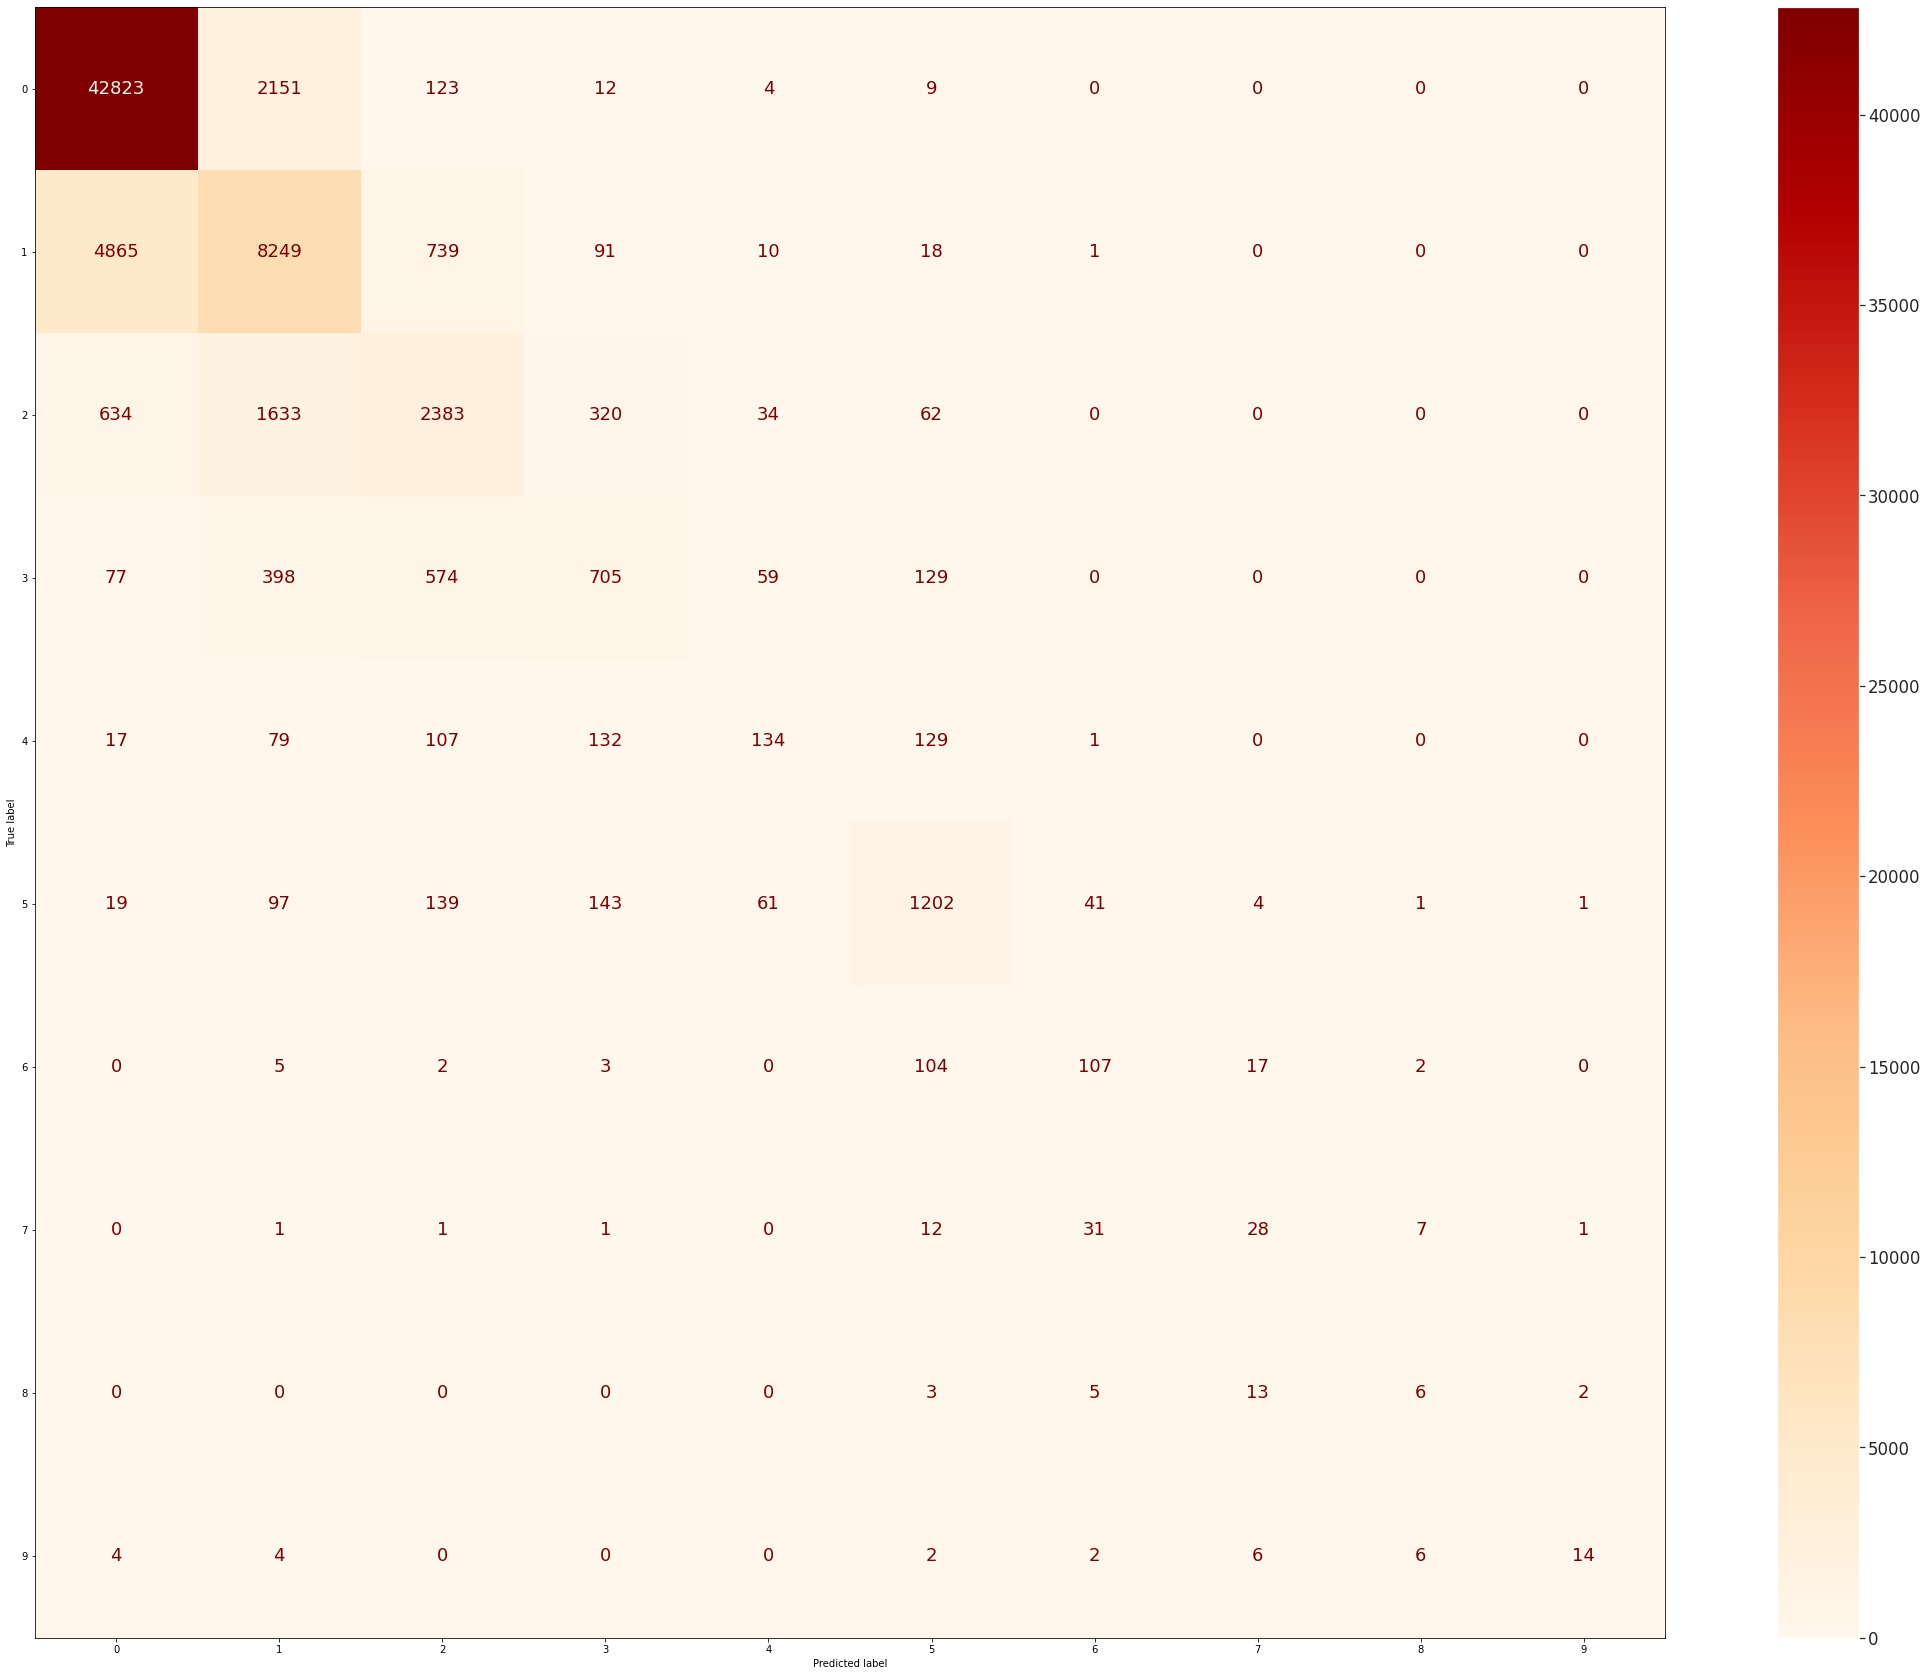

In [72]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(40, 30))
plt.grid(False)
sns.set(font_scale=1.5)
plot_confusion_matrix(reg, X_test[list_features], y_test,cmap="OrRd",ax = ax)  
plt.show()


Text(0.5, 0, 'XGB Feature Importance')

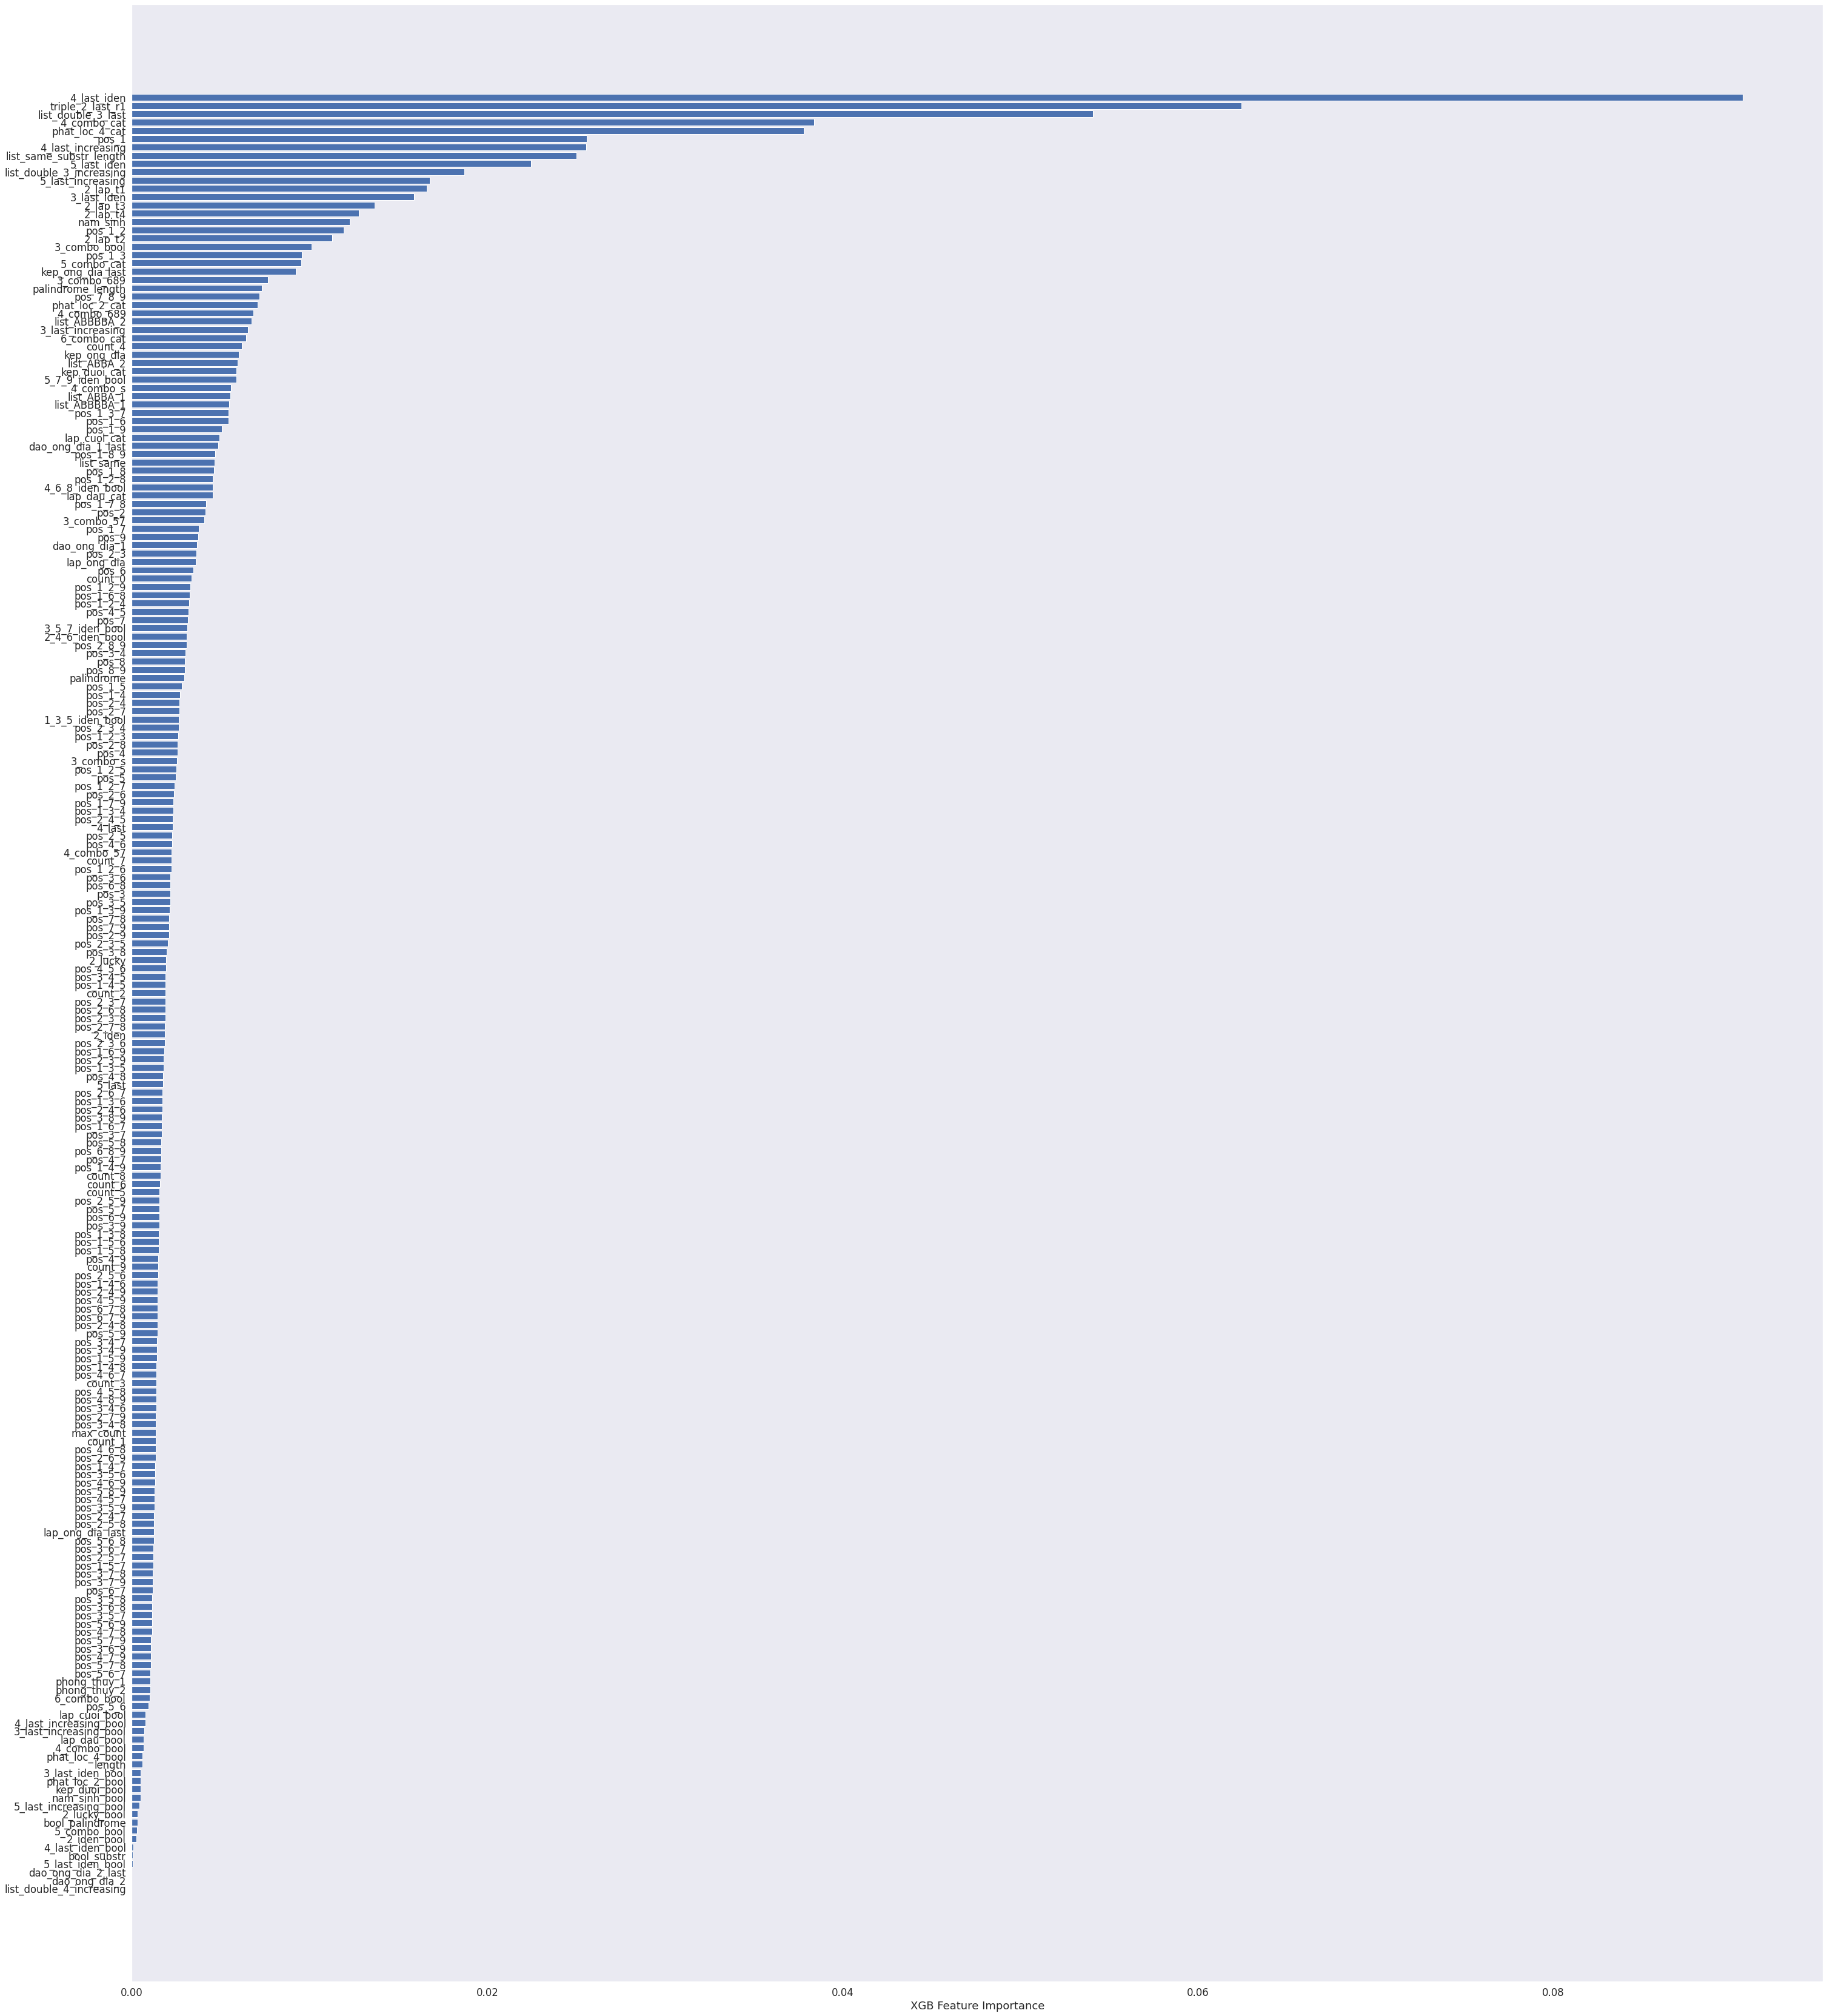

In [73]:
plt.figure(figsize = (50,60))
plt.grid(False)

sorted_idx = reg.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], reg.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")

In [74]:
import pickle
pickle.dump(ct, open("encoder_xgb.pkl", "wb"))
pickle.dump(reg, open("xgb_reg_final.pkl", "wb"))
# pickle.dump(clf,open("ct.pkl", "wb"))

In [75]:
# clf = CatBoostClassifier(task_type = "GPU", iterations = 1300,depth = 15)

# # ,iterations=1000,learning_rate = 0.15,depth =10)    
# # , ,cat_features = LIST_FEAT1 + LIST_FEAT2 + LIST_FEAT5 + LIST_FEAT6 + LIST_FEAT7 + LIST_FEAT8)
# clf.fit(X_train, y_train)
# y_train_predict = clf.predict(X_train)
# print("CBoost Accuracy Score of train set-> ",accuracy_score(y_train, y_train_predict)*100)

# y_test_predict = clf.predict(X_test)
# print(classification_report(y_test,y_test_predict))

In [76]:
def guess_price(number, model,encoder):
    df = pd.DataFrame()
    df['phone_number'] = [number[1:]]
    df = removing_wrong_phone_number(df)
    df = creating_10_feats_from_single_pos(df)
    df = features_from_counting_numbers(df)
    df = sim_nam_sinh(df)
    df = symetric_4length_and_samesubtring_features(df)
    df = combo_feat(df)
    df = count_combo_features(df)
    df = features_2_inden_and_2_lucky_last(df)
    df = last_special_case(df)
    df = features_from_sum(df)
    df = creating_features_by_combine_pos(df)
    df = sim_loc_phat(df)
    df = double_3_last(df)
    df = triple_2_last(df)
    df = sim_6_last(df)
    df = special_4_sim(df)
    df = ong_dia(df)
    df = special_6_last(df)
    df = increasing_3_4(df)
    df = check_easy_remember(df)
    df = encoder.encode(df)
    list_features = LIST_FEAT1 + LIST_FEAT2 + LIST_FEAT3 + LIST_FEAT4 + LIST_FEAT5 + LIST_FEAT6 + LIST_FEAT10 + LIST_FEAT9
    ans = model.predict(df[list_features])
 
    if(ans == 0):
        print("giá từ 0 đến 1,6tr vnd")
    elif ans == 1:
        print("giá từ 1,6 đến 3,6tr vnd")
    elif ans == 2:
        print("giá từ 3,6tr đến 6,5tr vnd")
    elif ans == 3:
        print("giá từ 6,5tr đến 10,8tr vnd")
    elif ans == 4:
        print("giá từ 10,8tr đến 15tr vnd")
    elif ans == 5:
        print("giá từ 15tr đến 61tr vnd")
    elif ans == 6:
        print("giá từ 61tr đến 150tr vnd")
    elif ans == 7:
        print("giá từ 150tr đến 310tr vnd")
    elif ans == 8:
        print("giá từ 310tr đến 530tr vnd")
    else:
        print("giá hơn 530tr")


In [77]:
a = pickle.load(open("./xgb_reg_final.pkl", "rb"))
encoder = pickle.load(open("./encoder_xgb.pkl", "rb"))

In [80]:
import time
start_time = time.time()
guess_price("0963126868",a,encoder)
print("run time is " + str(time.time() - start_time))

giá từ 15tr đến 61tr vnd
run time is 0.4153754711151123


In [79]:
# b = pickle.load(open("./cat.pkl", "rb"))
# encoder = pickle.load(open("./encoder.pkl", "rb"))